## Development of a composite land Degradation index from LiDAR- Derived Topographic and Vegetation Metric

**Author:**  
Agnes Anyomi


## Keywords and Definitions

Waveform: A lidar wave is the distribution of energy returning to the sensor,

Intensity: The amount of energy returned to the sensor

Lidar file format Lidar Point Clouds is so big that they have their own file format. Compressed file format is .laz

Lidar numbers come with special information. In general, they have x, y, z (height) values. Most data sets have intensity values, and sometimes they have a classification which means that the points were assigned a category of construction, vegetation, land, etc. to the points. This is useful because it helps to create an understanding of data and visualize the point cloud.

## Motivation

Land degradation is a significant threat to ecosystem services, agricultural productivity and long -term sustainability. To have effective land management and conservation strategies, early detection and quantification is necessary. Traditional region -based assessments are often limited and locally limited. The study benefits from high-resolution lidar data and  geospatial analysis  which develops a quantitative structure to assess land degradation at scale, allowing more effective monitoring, initial warning and date-driven decisions.

## Description of the dataset

A sample is included in the Lidar Dataset (france.laz), also found in LASTools which represents 10 points/metres square airborne Lidar acquired by IGN from France under the Lidar HD program.

It is expected to be completed by 2026, the entire Lidar HD initiative, using aircraft-equipped scanner, will collect approximately 3 PB point clouds to cover metropolitan France at 10 points/metres using aircraft-equipped scanners.

https://www.actuia.com/en/news/the-national-lidar-hd-programme-3d-mapping-of-the-entire-french-territory

## Data Characteristics

The dataset includes X, Y, Z coordinates, intensity, return numbers and classification values, after LAS v1.4 conventions.

For analysis, LAStools and CloudCompare were used:

LasView to inspect the Scaler field including Color, Intensity and Return

CloudCompare to find the Canopy Height Model(CHM)

Python automated LiDAR data processing, terrain and vegetation metric extraction, and computation of the Land Degradation Index.

## Rationale for Sample Dataset

The sample data enables replicable tutorials that reflect the feature attributes of LiDAR dataset.

## Visualizing the point cloud Data

Color by Return: Vegetation has many returns while the building only has 1 Return

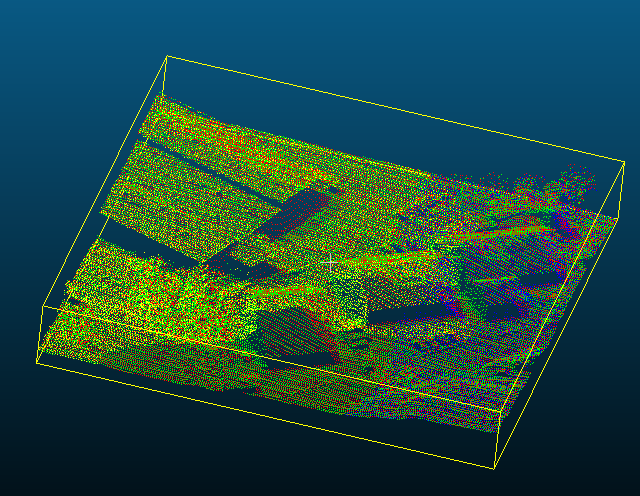

Point cloud colour by Intensity: Vegetation has low intensity (darker) due to dissolution of pulses as shown below

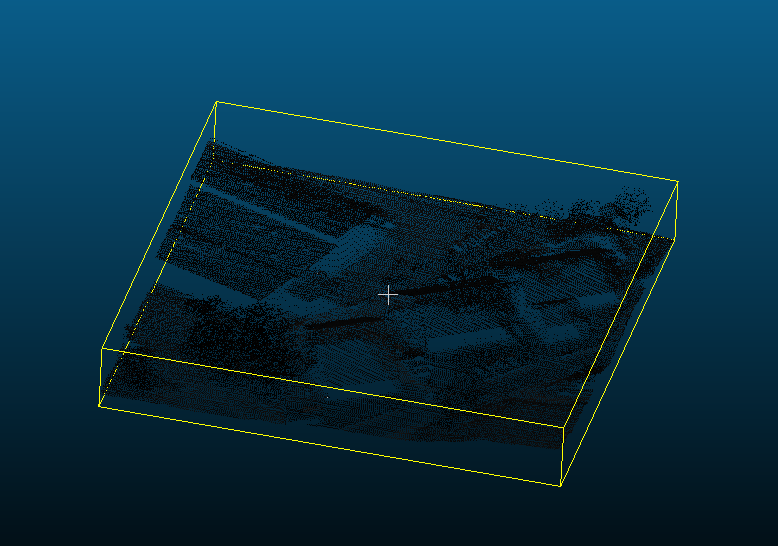

## Height by Color

The land is dense and keeps height above the ground, the sea level etc.

The Z value(eleveation) for each point is mapped in a color on a gradient (for example: blue = low, green = medium, red = high).

This gives a visual sense of terrain, slope, hills, valleys, buildings and more of the area.

This is a quick and easy way to understand the vertical structure of the landscape.

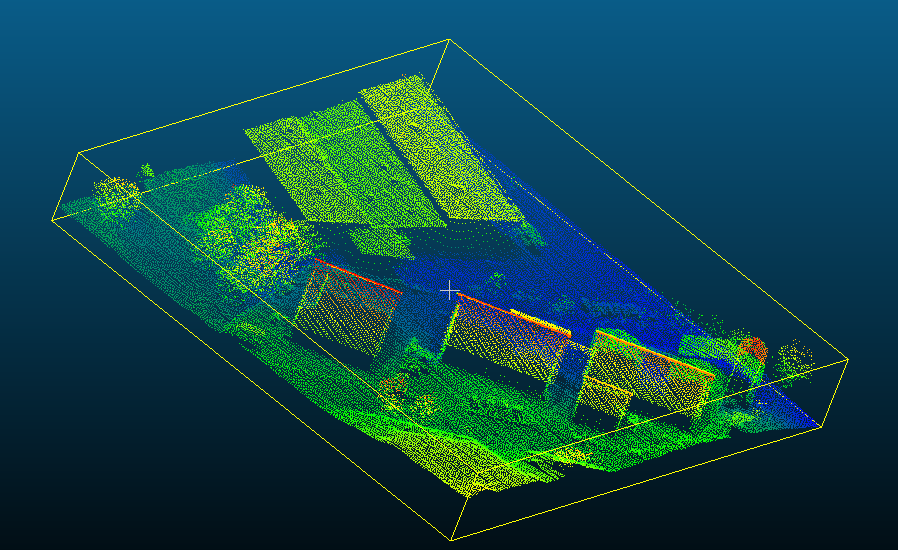

## Finding TIN

TIN means Triangle Irregular Networks. There is a surface model made by adding a set of irregularly spaced points (eg Lidar) to a non-overlapping triangles based on 3D positions.

Why is TIN needed?
It preserves the terrain Detail unlike the raster DEMs (average data in the grids). However, the TIN maintains accurate geometry between geometry points. This is important when modeling sharp features such as ridges,cliffs, gullies or building edges.

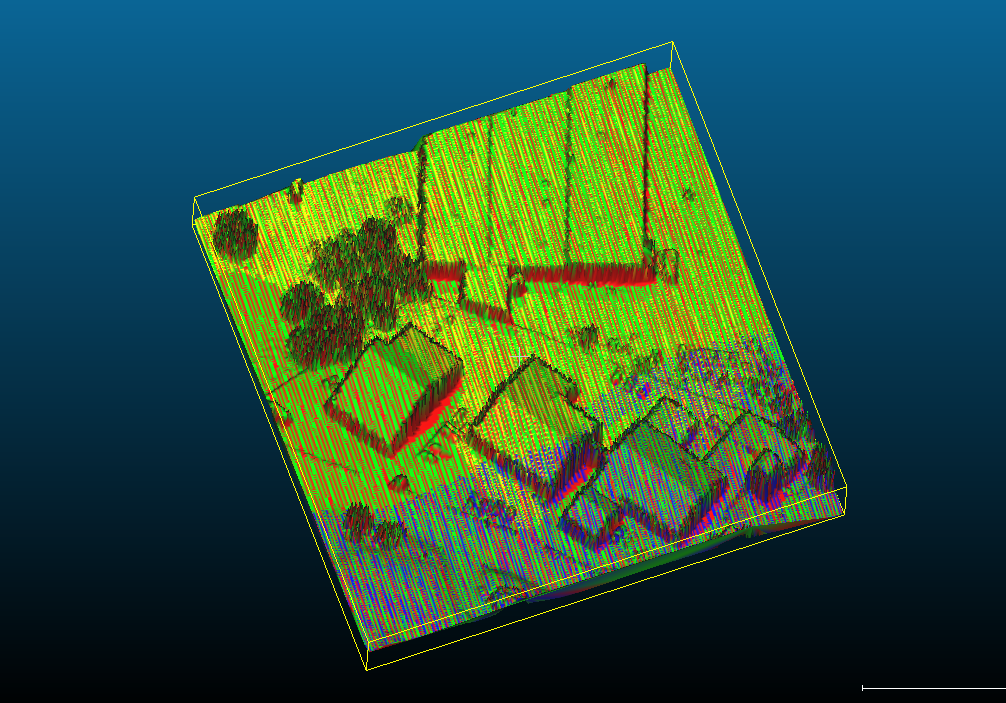

## DEM

DEM = Digital Elevation Model (ground only). This is the bare earth. Usually if the DEM is mostly flat, it may just appear all blue.[1]

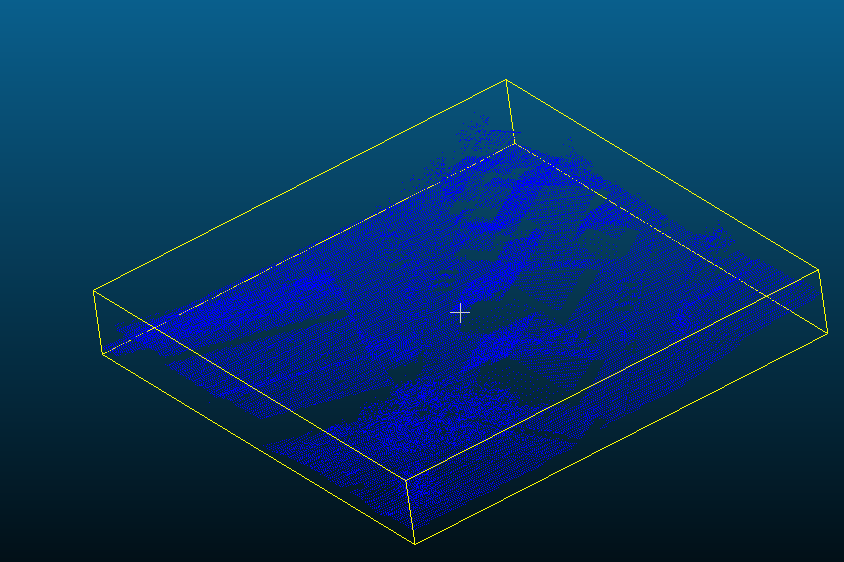


## DSM

DSM = Digital Surface Model (ground + trees + buildings)

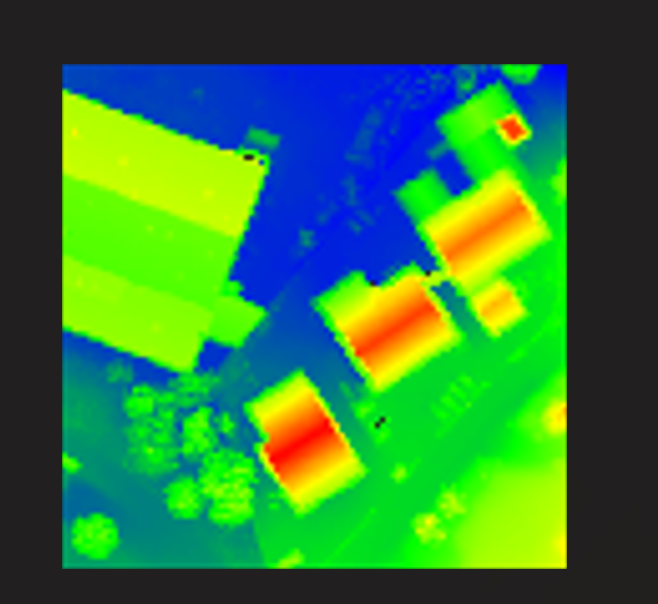

# DSM - DEM = vegetation height / elevation of features above ground

DSM - DEM → get a canopy height model (CHM)

Use this to:

Detect degraded zones (bare patches)

Quantify gully depths

## Computed values

ComputeDistances: mean distance = 0.148152 m / standard deviation = 0.377411 m

| Statistic              | Value    | Meaning                                                                    |
| ---------------------- | -------- | -------------------------------------------------------------------------- |
| **Mean Canopy Height** | \~0.15 m | The average height of vegetation/objects above ground is \~15 centimeters. |
| **Standard Deviation** | \~0.38 m | The variation in height across your study area is about 38 centimeters.    |


Land degradation and interpretation and forest context

An average canopy of just 15 cm is very low.

This strongly suggests:

The area can be largely be bare soil, degraded land, cleared land or early regrowth.

Very low mature vegetation.

Low mean canopy height obtained from DSM - DEM analysis indicates minimum vegetative cover, consistent with deforestation, overgrazing or soil erosion.

## Land degradation analysis

We go ahead to converts raw Lidar points into a gridded elevation to visualise and quantify of land degradtion patterns.

We see topographic difference between areas representing high height (potential lines or piles).

The blue regions represent low height (valleys, depression or potential wetland zones).

Green/yellow fields represent the middle level area.

Index(['X', 'Y', 'Z', 'Point Source ID', 'Scan Angle Rank',
       'Number of Returns', 'Return Number', 'Time', 'Intensity'],
      dtype='object')


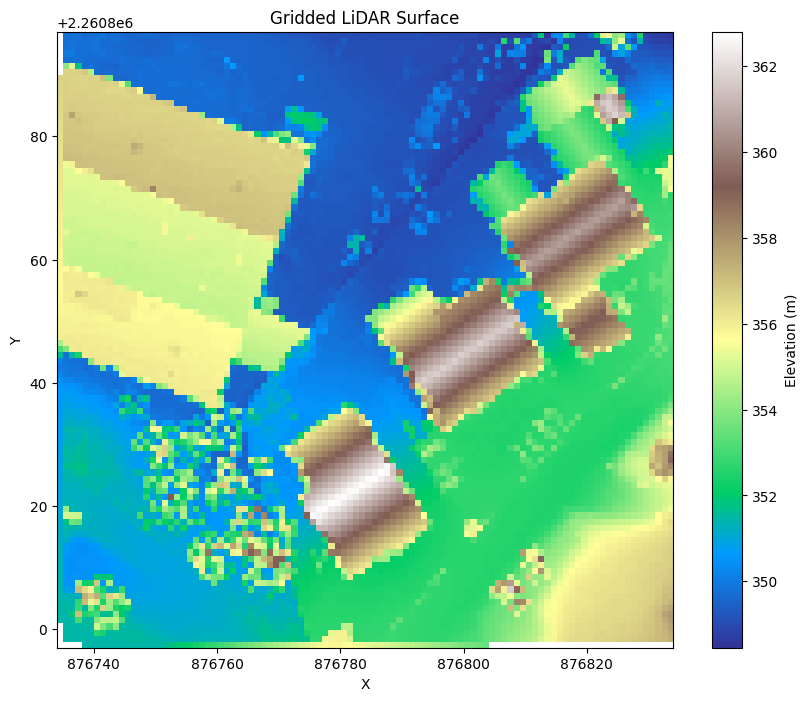

In [1]:
## The Python code converts raw LiDAR points into a gridded elevation surface to visualize and quantify land degradation patterns.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from scipy.ndimage import generic_filter

# STEP 1 — Load your LiDAR data
df = pd.read_csv('/content/france - Cloud.csv')

# Check what columns you have
print(df.columns)

# For this example, we assume columns: 'X', 'Y', 'Z'
x = df['X'].values
y = df['Y'].values
z = df['Z'].values

# STEP 2 — Define grid resolution
grid_size = 1.0  # meters

# Build grid boundaries
xmin, xmax = x.min(), x.max()
ymin, ymax = y.min(), y.max()

# Create grid coordinates
xi = np.arange(xmin, xmax, grid_size)
yi = np.arange(ymin, ymax, grid_size)
xi, yi = np.meshgrid(xi, yi)

# STEP 3 — Interpolate LiDAR points into the grid
# The linear interpolation helps to estimate Z for each grid cell.
zi = griddata(
    points=(x, y),
    values=z,
    xi=(xi, yi),
    method='linear'
)

# STEP 4 — Plot the gridded LiDAR data
plt.figure(figsize=(10, 8))
plt.imshow(zi, extent=(xmin, xmax, ymin, ymax), origin='lower', cmap='terrain')
plt.colorbar(label='Elevation (m)')
plt.title('Gridded LiDAR Surface')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()





Next, we calculates the local elevation variability (standard deviation for height) in the 3x3 pixel neighborhoods across LiDAR DEM , and displays the result as a surface roughness.


From the plot below, we observe that;
Bright Yellow Zone (~ 5 meters roughness): potential man -made structures (eg roof or walls) or heavily humiliated areas (eg Deep Guliz).

Green to teal (~ 2–3 m): mild erosion zones, disturbed soil, and patchy vegatation areas.

Dark purple to blue (<1 m): flat areas, possibly bare or compact soil with small vegetation, tyoical in heavily degradaed or overused land.

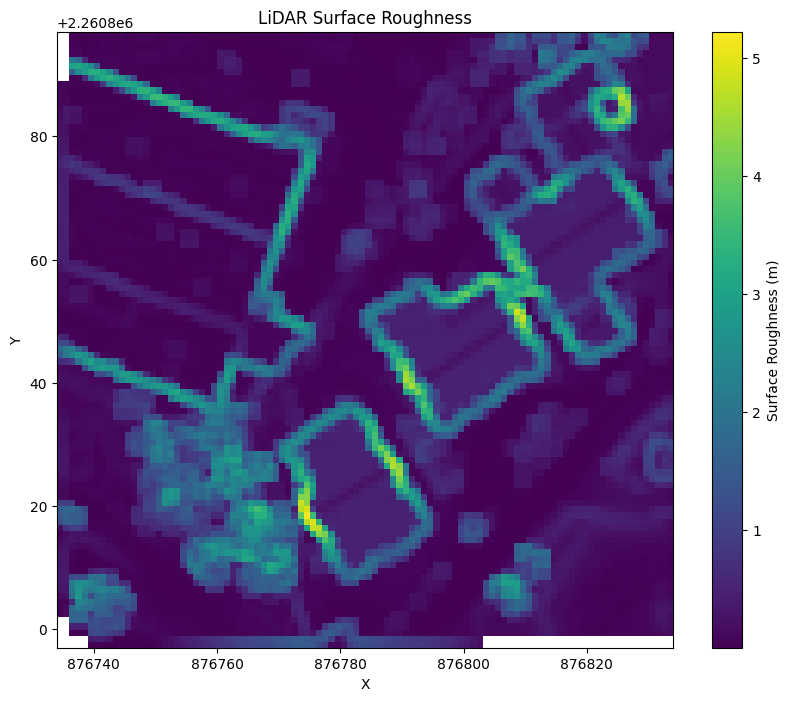

In [2]:
# SECTION 2: Surface Roughness

from scipy.ndimage import generic_filter

# Apply generic_filter to the gridded elevation data
roughness = generic_filter(zi, np.std, size=3)

# Optional: plot the roughness map
plt.figure(figsize=(10, 8))
plt.imshow(roughness, extent=(xmin, xmax, ymin, ymax), origin='lower', cmap='viridis')
plt.colorbar(label='Surface Roughness (m)')
plt.title('LiDAR Surface Roughness')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()


## Slope and Aspect
The roughness, slope and aspect of the lidar height data. These are important matrix, as they help identify the risk of erosion of land by determining surface volatility (roughness), erosion capacity (slope) and microclimatic exposure (aspect).



# Bright yellow borders in slope map;
Indicate steep slopes which are associated with high erosion risk, especially in areas adjacent to built structures where runoff may be concentrated.


 ## Flat, dark zones in slope map;
Suggest compacted or sealed surfaces which represent degraded areas if natural vegetation cover has been lost or if soil sealing has occurred.

## Cyan-colored zones in aspect map;
(south-facing slopes)	South-facing slopes experience higher sun exposure, leading to increased drying, which can accelerate vegetation stress and degradation.

## Patchy, colorful terrain in aspect map;
Reflects disturbed topography, possibly resulting from active erosion, land reshaping, or previous degradation interventions.[2]


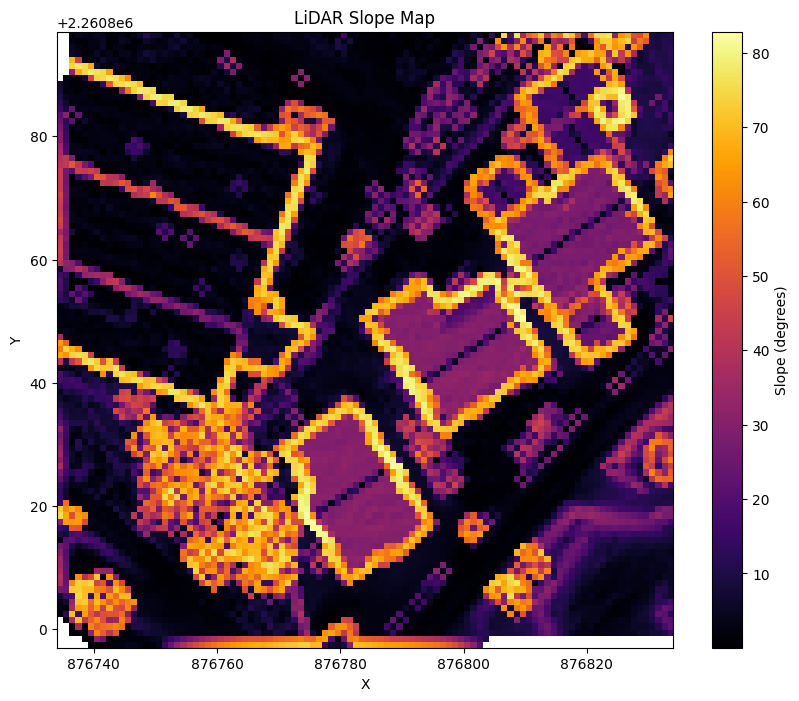

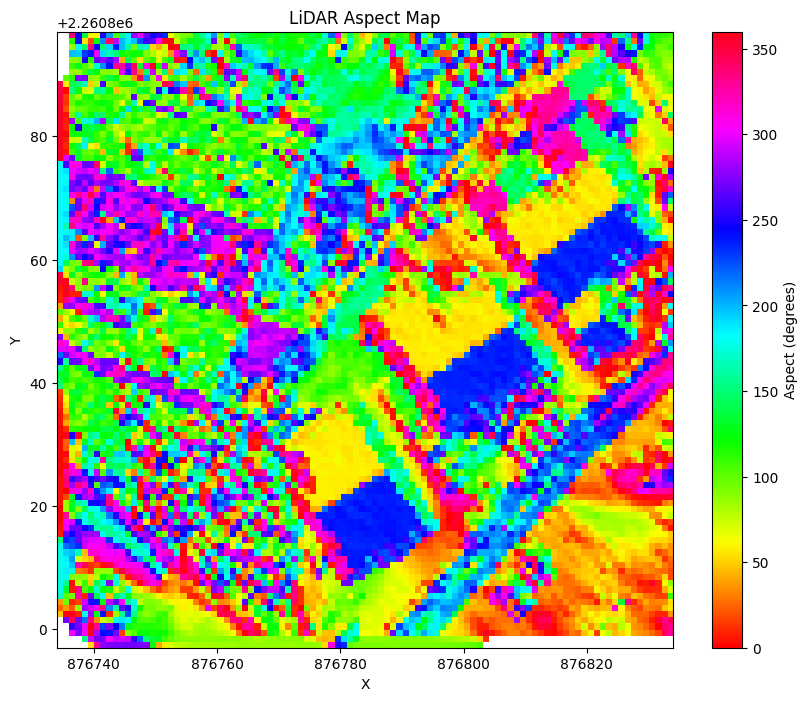

In [5]:
# SECTION 3: Slope and Aspect

# Calculate gradients on gridded data (zi)
dz_dy, dz_dx = np.gradient(zi, grid_size, grid_size)

# Slope in degrees
slope = np.degrees(np.arctan(np.sqrt(dz_dx**2 + dz_dy**2)))

# Aspect in degrees
aspect = np.degrees(np.arctan2(-dz_dy, dz_dx)) % 360

# Plot Slope
plt.figure(figsize=(10, 8))
plt.imshow(slope, extent=(xmin, xmax, ymin, ymax), origin='lower', cmap='inferno')
plt.colorbar(label='Slope (degrees)')
plt.title('LiDAR Slope Map')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

# Plot Aspect
plt.figure(figsize=(10, 8))
plt.imshow(aspect, extent=(xmin, xmax, ymin, ymax), origin='lower', cmap='hsv')
plt.colorbar(label='Aspect (degrees)')
plt.title('LiDAR Aspect Map')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()


This step analyzes LiDAR intensity variation to serve as a proxy for vegetation structure. Areas with low variation may indicate degraded or bare land, while high variation suggests healthy, diverse vegetation cover.

In [6]:
# Extract intensity column
intensity = df['Intensity'].values

# Interpolate intensity onto the same grid
intensity_grid = griddata(
    points=(x, y),
    values=intensity,
    xi=(xi, yi),
    method='linear'
)


In [7]:
from scipy.ndimage import generic_filter

# Define CV function for filter
def coefficient_of_variation(arr):
    if np.mean(arr) == 0:
        return np.nan
    return np.std(arr) / np.mean(arr)

# Apply 3x3 moving window
intensity_cv = generic_filter(intensity_grid, coefficient_of_variation, size=3)


This grid terrain calculates data (xi, yi, zi) in multiple terrains (slope, aspects, roughness and intensity coefficients for variation in the form of a vegetative proxy). This levels 1D matrices, adding them to a single data frame, removing rows of with missing height values ​​to ensure data quality, and export pure data sets (lidar_full_surface_metrics.csv). This processed dataset converts Raw Lidar into scientific analysis, vegetation monitoring, landfall evaluation and a structured form designed to predict risk.[2]

In [8]:
#Surface Metrics Export"

# Flatten everything
flat_x = xi.flatten()
flat_y = yi.flatten()
flat_z = zi.flatten()
flat_slope = slope.flatten()
flat_aspect = aspect.flatten()
flat_rough = roughness.flatten()
flat_intensity_cv = intensity_cv.flatten()

# Build DataFrame
grid_df = pd.DataFrame({
    'X': flat_x,
    'Y': flat_y,
    'Z': flat_z,
    'Roughness': flat_rough,
    'Slope': flat_slope,
    'Aspect': flat_aspect,
    'Intensity_CV': flat_intensity_cv
})

# Remove NaN rows (optional but recommended)
grid_df = grid_df.dropna(subset=['Z'])

# Export if needed
grid_df.to_csv('lidar_full_surface_metrics.csv', index=False)



## Land Degradation Index Calculation

The aspect normalizes roughness, slope, and intensity coefficient of variation to a 0–1 scale. It computes a composite Land Degradation Score as the mean of the normalized metrics. Finally, it visualizes the score distribution and outputs sample data for inspection.

## Analysis

 **Land Degradation Score Distribution (Histogram):**

The x-axis represents the normalized Degradation Score (typically ranging from 0 to 1, where 0 is low degradation and 1 is high degradation).

The y-axis represents how many grid cells fall into each score range (bin).

The shape of the histogram gives an overview of the overall degradation status of the study area. For example, a peak near 0 would suggest most of the area has low degradation, while a peak near 1 would suggest high degradation is common. A spread across the range indicates varying levels of degradation.


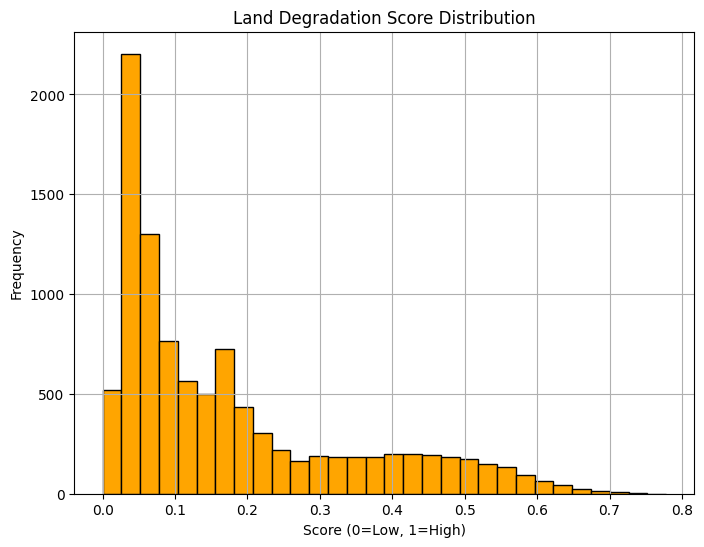

          X          Y           Z  Roughness     Slope      Aspect  \
0  876738.0  2260797.0  351.440662        NaN       NaN         NaN   
1  876739.0  2260797.0  351.442383   0.001669  0.168349   54.126660   
2  876740.0  2260797.0  351.444105   0.005149  0.112246  331.508383   
3  876741.0  2260797.0  351.445827   0.010148  0.766212  277.397087   
4  876742.0  2260797.0  351.447549   0.015442  1.666133  273.393521   

   Intensity_CV  Degradation_Score  
0           NaN                NaN  
1      0.113261           0.022817  
2      0.137206           0.028189  
3      0.143841           0.032630  
4      0.135826           0.034792  


In [14]:
# SECTION 5: Land Degradation Score (Combined Index)

#If youre running this code after exporting, you may want to first load the file
grid_df = pd.read_csv('lidar_full_surface_metrics.csv')


# Normalize metrics to 0-1 scale
for col in ['Roughness', 'Slope', 'Intensity_CV']:
    min_val = grid_df[col].min()
    max_val = grid_df[col].max()
    grid_df[col + '_norm'] = (grid_df[col] - min_val) / (max_val - min_val)

# Weighted average (equal weights for now)
grid_df['Degradation_Score'] = grid_df[['Roughness_norm', 'Slope_norm', 'Intensity_CV_norm']].mean(axis=1)

# Visualize histogram of scores
plt.figure(figsize=(8, 6))
plt.hist(grid_df['Degradation_Score'].dropna(), bins=30, color='orange', edgecolor='black')
plt.title('Land Degradation Score Distribution')
plt.xlabel('Score (0=Low, 1=High)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Display sample data
print(grid_df[['X', 'Y', 'Z', 'Roughness', 'Slope', 'Aspect', 'Intensity_CV', 'Degradation_Score']].head())


In [15]:
# Save the updated DataFrame to a new CSV
grid_df.to_csv('lidar_surface_with_degradation_score.csv', index=False)

print("✅ File saved as 'lidar_surface_with_degradation_score.csv'")


✅ File saved as 'lidar_surface_with_degradation_score.csv'


The shape of the histogram shows that it is right skewed (near 0), suggesting relatively healthy or less degraded landscape.

The peak with a large scale on the left show that the vast majority of the study area have low risk of land degradation. These are possibly stable or flat fields. The small columns to the right indicate that there are few low areas with moderate to high degradation risk.

## Recommendations

Right-skewed distribution suggests that most of the landscapes are currently stable with the risk of low degradation risk. However, the presence of cells with moderate to high degradation scores indicates localized areas that may require targeted monitoring, preventive soil protection or land management intervention to prevent further degradation.

## Future Works

Future work involves the building of a machine learning pipelines to predict landdegradation using terrain and vegetative matrix. The Monte Carlo simulation will create a model for uncertainty under different environmental scenarios. Hyperparameter will support the large study areas and modeling of large-scale monitoring and decision -making.

## References

1. Guth, P. L., Van Niekerk, A., Grohmann, C. H., Muller, J. P., Hawker, L., Florinsky, I. V., ... & Strobl, P. (2021). Digital elevation models: Terminology and definitions. Remote Sensing, 13(18), 3581.

2. Hodgson, M. E., Jensen, J., Raber, G., Tullis, J., Davis, B. A., Thompson, G., & Schuckman, K. (2005). An evaluation of lidar-derived elevation and terrain slope in leaf-off conditions. Photogrammetric Engineering & Remote Sensing, 71(7), 817-823.

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


In [13]:
# # Replace with the actual filename or DataFrame
# df = pd.read_csv('/content/france - Cloud.csv')  # Or use your existing DataFrame if already loaded
# df.head()


In [16]:
# Replace with the actual filename or DataFrame
dff = pd.read_csv('/content/lidar_surface_with_degradation_score.csv')  # Or use your existing DataFrame if already loaded
dff.head()

,X,Y,Z,Roughness,Slope,Aspect,Intensity_CV,Roughness_norm,Slope_norm,Intensity_CV_norm,Degradation_Score
0,876738.0,2260797.0,351.440662,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,876739.0,2260797.0,351.442383,0.001669,0.168349,54.126660,0.113261,0.000003,0.001790,0.066659,0.022817
2,876740.0,2260797.0,351.444105,0.005149,0.112246,331.508383,0.137206,0.000670,0.001113,0.082785,0.028189
3,876741.0,2260797.0,351.445827,0.010148,0.766212,277.397087,0.143841,0.001627,0.009010,0.087253,0.032630
4,876742.0,2260797.0,351.447549,0.015442,1.666133,273.393521,0.135826,0.002642,0.019878,0.081856,0.034792


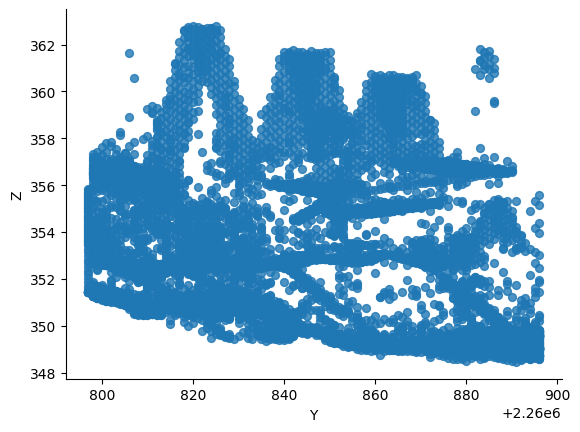

In [33]:
# @title Y vs Z

from matplotlib import pyplot as plt
dff.plot(kind='scatter', x='Y', y='Z', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

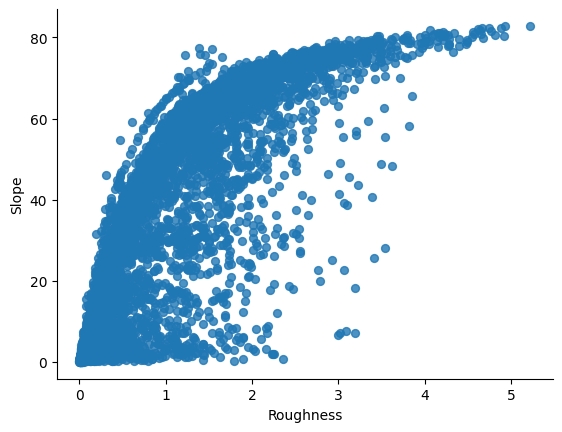

In [32]:
# @title Roughness vs Slope

from matplotlib import pyplot as plt
dff.plot(kind='scatter', x='Roughness', y='Slope', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

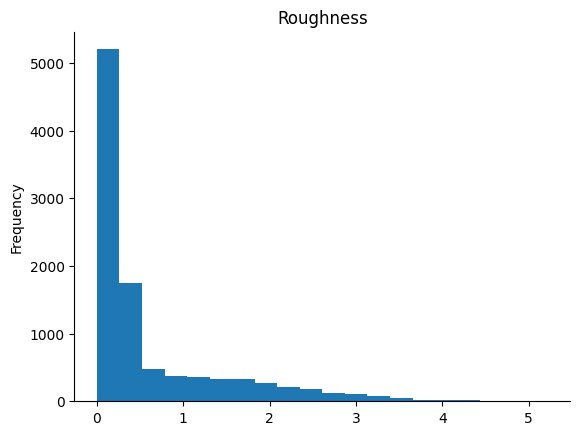

In [31]:
# @title Roughness

from matplotlib import pyplot as plt
dff['Roughness'].plot(kind='hist', bins=20, title='Roughness')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [30]:
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=dff)

https://docs.google.com/spreadsheets/d/1iOONllYpcZStv9Z0gx3dnYFq1zlUlcYfNj_76DQKtik/edit#gid=0


In [17]:
# Select relevant features and target
features = ['Roughness', 'Slope', 'Aspect', 'Intensity_CV']
target = 'Degradation_Score'

# Drop rows with missing values
dff_clean = dff.dropna(subset=features + [target])

# Separate inputs and output
X = dff_clean[features]
y = dff_clean[target]


In [20]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [19]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Build a regression pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Train the model
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('rf', RandomForestRegressor(random_state=42))])

Root Mean Squared Error (RMSE): 0.0072
R² Score: 0.9981


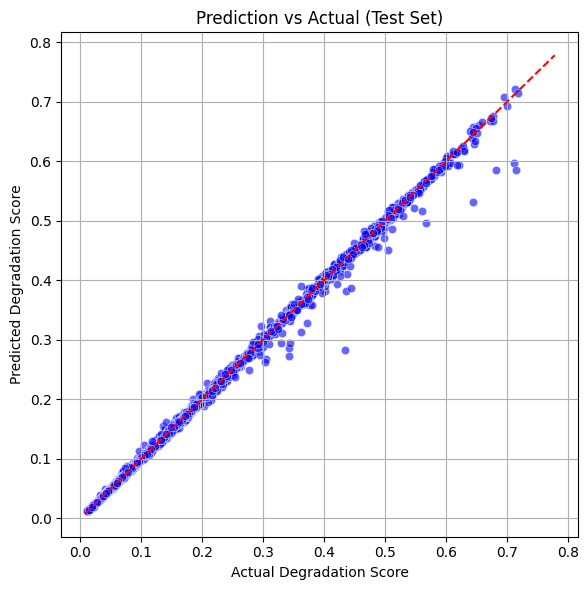

In [21]:
# Predict on the test set
y_pred = pipeline.predict(X_test)

# Evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

# Scatter plot: Predicted vs Actual
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, color='blue')
plt.plot([y.min(), y.max()], [y.min(), y.max()], '--r')
plt.xlabel("Actual Degradation Score")
plt.ylabel("Predicted Degradation Score")
plt.title("Prediction vs Actual (Test Set)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [22]:
from sklearn.model_selection import cross_val_score

# 5-fold cross-validation using R² as the scoring metric
cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='r2')

# Display results
print("Cross-validation R² scores for each fold:", cv_scores)
print(f"Mean R² from cross-validation: {np.mean(cv_scores):.4f}")


Cross-validation R² scores for each fold: [0.99880004 0.99763039 0.99501973 0.99943324 0.99951044]
Mean R² from cross-validation: 0.9981


In [23]:
from sklearn.utils import resample

n_simulations = 100  # Number of Monte Carlo iterations
all_predictions = []

for i in range(n_simulations):
    # Bootstrap resampling
    X_resampled, y_resampled = resample(X_train, y_train, random_state=i)

    # Rebuild and train the pipeline
    mc_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('rf', RandomForestRegressor(n_estimators=100, random_state=i))
    ])
    mc_pipeline.fit(X_resampled, y_resampled)

    # Predict on the same test set
    preds = mc_pipeline.predict(X_test)
    all_predictions.append(preds)

# Convert to NumPy array: shape (n_simulations, n_test_samples)
all_predictions = np.array(all_predictions)

# Compute mean and std for each test sample
prediction_means = all_predictions.mean(axis=0)
prediction_stds = all_predictions.std(axis=0)


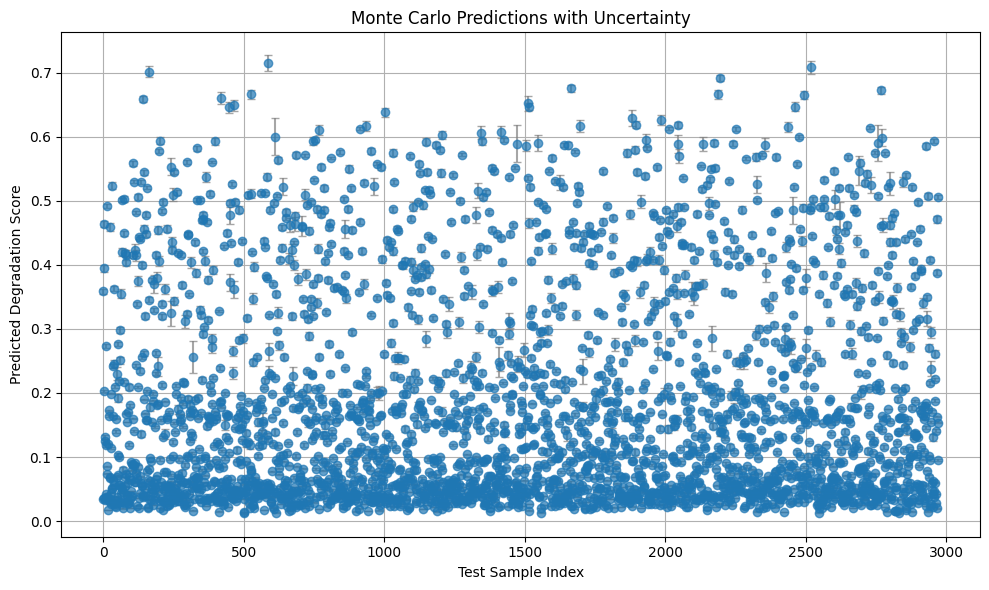

In [24]:
# Plot predicted means with uncertainty (±1 std dev)
plt.figure(figsize=(10, 6))
plt.errorbar(range(len(y_test)), prediction_means, yerr=prediction_stds, fmt='o', ecolor='gray', alpha=0.7, capsize=3)
plt.title("Monte Carlo Predictions with Uncertainty")
plt.xlabel("Test Sample Index")
plt.ylabel("Predicted Degradation Score")
plt.grid(True)
plt.tight_layout()
plt.show()


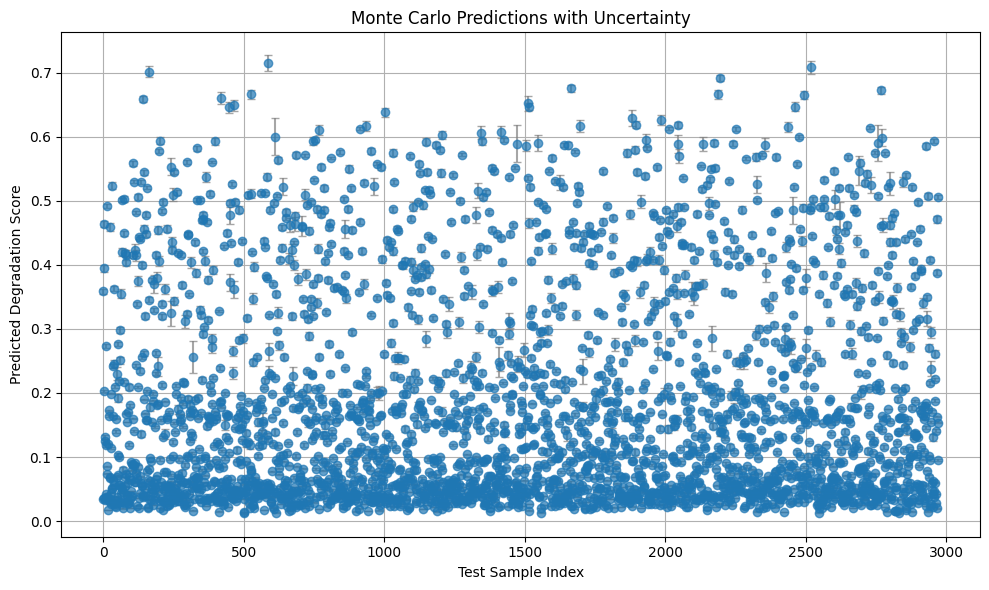

In [25]:
# Plot predicted means with uncertainty (±1 std dev)
plt.figure(figsize=(10, 6))
plt.errorbar(range(len(y_test)), prediction_means, yerr=prediction_stds, fmt='o', ecolor='gray', alpha=0.7, capsize=3)
plt.title("Monte Carlo Predictions with Uncertainty")
plt.xlabel("Test Sample Index")
plt.ylabel("Predicted Degradation Score")
plt.grid(True)
plt.tight_layout()
plt.show()


In [26]:
# Create a DataFrame for results
mc_results = pd.DataFrame({
    'Actual_Score': y_test.values,
    'Predicted_Mean': prediction_means,
    'Prediction_Uncertainty': prediction_stds
})

# Optional: reset index to make it clean
mc_results.reset_index(drop=True, inplace=True)

# Save to CSV
mc_results.to_csv('monte_carlo_degradation_predictions.csv', index=False)

print("✅ Monte Carlo results saved to 'monte_carlo_degradation_predictions.csv'")


✅ Monte Carlo results saved to 'monte_carlo_degradation_predictions.csv'


In [27]:
pip install streamlit


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 76.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 132.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 5.3 MB/s eta 0:00:00


In [28]:
# Match X, Y from test set
spatial_df = X_test.copy()
spatial_df['X'] = dff_clean.loc[X_test.index, 'X']
spatial_df['Y'] = dff_clean.loc[X_test.index, 'Y']
spatial_df['Actual'] = y_test.values
spatial_df['Predicted'] = prediction_means
spatial_df['Uncertainty'] = prediction_stds


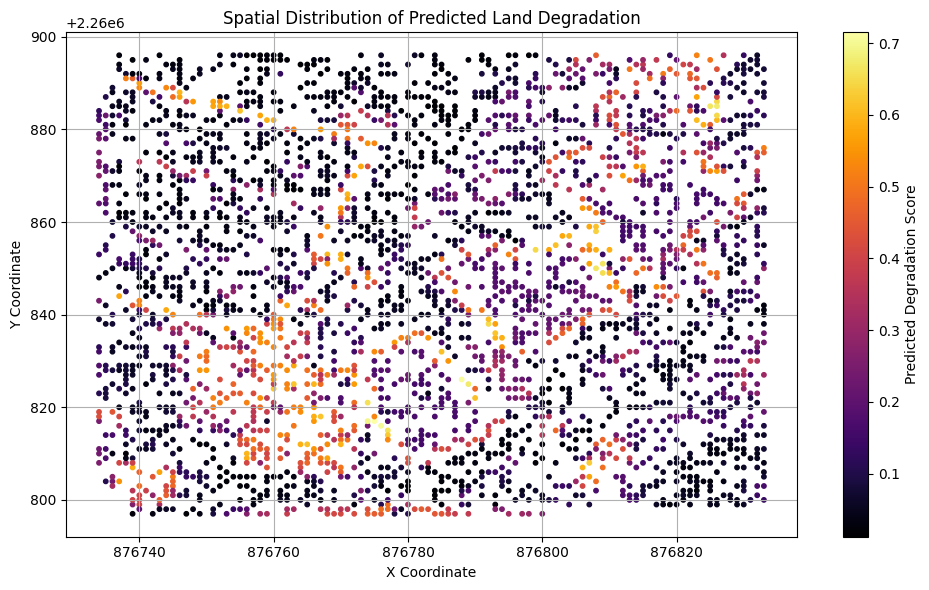

In [29]:
plt.figure(figsize=(10, 6))
plt.scatter(spatial_df['X'], spatial_df['Y'], c=spatial_df['Predicted'], cmap='inferno', s=10)
plt.colorbar(label='Predicted Degradation Score')
plt.title("Spatial Distribution of Predicted Land Degradation")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.grid(True)
plt.tight_layout()
plt.show()
